In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer, ConvolutionalLayer, MaxPoolingLayer, Flattener
from model import ConvNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_X = train_X.astype(float) / 255.0
    test_X = test_X.astype(float) / 255.0

    # Subtract mean
    mean_image = np.mean(train_X, axis = 0)
    train_X -= mean_image
    test_X -= mean_image

    return train_X, test_X

train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

In [7]:
# TODO: Implement ConvolutionaLayer that supports only 1 output and input channel

# Note: now you're working with images, so X is 4-dimensional tensor of
# (batch_size, height, width, channels)

X = np.array([
              [
               [[1.0], [2.0]],
               [[0.0], [-1.0]]
              ]
              ,
              [
               [[0.0], [1.0]],
               [[-2.0], [-1.0]]
              ]
             ])

# Batch of 2 images of dimensions 2x2 with a single channel
print("Shape of X:",X.shape)

layer = ConvolutionalLayer(in_channels=1, out_channels=1, filter_size=2, padding=0)
print("Shape of W", layer.W.value.shape)
layer.W.value = np.zeros_like(layer.W.value)
layer.W.value[0, 0, 0, 0] = 1.0
layer.B.value = np.ones_like(layer.B.value)
result = layer.forward(X)

assert result.shape == (2, 1, 1, 1)
assert np.all(result == X[:, :1, :1, :1] +1), "result: %s, X: %s" % (result, X[:, :1, :1, :1])


# Now let's implement multiple output channels
layer = ConvolutionalLayer(in_channels=1, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)


# And now multple input channels!
X = np.array([
              [
               [[1.0, 0.0], [2.0, 1.0]],
               [[0.0, -1.0], [-1.0, -2.0]]
              ]
              ,
              [
               [[0.0, 1.0], [1.0, -1.0]],
               [[-2.0, 2.0], [-1.0, 0.0]]
              ]
             ])

print("Shape of X:", X.shape)
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)

Shape of X: (2, 2, 2, 1)
Shape of W (2, 2, 1, 1)
Shape of X: (2, 2, 2, 2)


In [10]:
# First test - check the shape is right
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape

# Actually test the backward pass
# As usual, you'll need to copy gradient check code from the previous assignment
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_gradient(layer, X)

layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'W')
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


In [11]:
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
result = layer.forward(X)
# Note this kind of layer produces the same dimensions as input
assert result.shape == X.shape,"Result shape: %s - Expected shape %s" % (result.shape, X.shape)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape
print(X.shape)
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_gradient(layer, X)

(2, 2, 2, 2)
Gradient check passed!


In [12]:
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_param_gradient(layer, X, 'W')

Gradients are different at (0, 0, 0, 0). Analytic: -0.01988, Numeric: -1.18850


AssertionError: 

In [13]:
pool = MaxPoolingLayer(2, 2)
result = pool.forward(X)
assert result.shape == (2, 1, 1, 2)

assert check_layer_gradient(pool, X)

Gradient check passed!


In [14]:
X_test = np.array([
    [[[1.0], [2.0], [2.0], [2.0]], [[3.0], [4.0], [2.0], [2.0]], [[3.0], [4.0], [2.0], [2.0]], [[3.0], [4.0], [2.0], [2.0]]],
    [[[7.0], [9.0], [1.0], [2.0]], [[3.0], [5.0], [7.0], [1.0]], [[3.0], [8.0], [4.0], [4.0]], [[5.0], [9.0], [7.0], [3.0]]]
])
pool = MaxPoolingLayer(2, 2)
result = pool.forward(X_test)
assert result.shape == (2, 2, 2, 1)

assert check_layer_gradient(pool, X_test)

Gradients are different at (0, 0, 2, 0). Analytic: -0.19503, Numeric: -0.09751


AssertionError: 

In [15]:
flattener = Flattener()
result = flattener.forward(X)
assert result.shape == (2,8)

assert check_layer_gradient(flattener, X)

Gradient check passed!


In [18]:
# TODO: In model.py, implement missed functions function for ConvNet model

# Use regularization on fully-connected layer only
print(train_X[:2].shape)
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])
# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

(2, 32, 32, 3)
Checking gradient for WC1
Gradients are different at (0, 0, 0, 0). Analytic: -0.00060, Numeric: 0.01268


False

In [19]:
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for WC1
Gradients are different at (0, 0, 0, 0). Analytic: 0.00512, Numeric: 0.00285


False

In [21]:
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2, reg = 1e-2)
dataset = Dataset(train_X[:16], train_y[:16], val_X[:16], val_y[:16])
trainer = Trainer(model, dataset, SGD(), batch_size=16, learning_rate=1e-1)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.300616, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 4.008983, Train accuracy: 0.187500, val accuracy: 0.062500
Loss: 9.163836, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 5.422526, Train accuracy: 0.125000, val accuracy: 0.187500
Loss: 2.664126, Train accuracy: 0.125000, val accuracy: 0.000000
Loss: 2.327602, Train accuracy: 0.125000, val accuracy: 0.062500
Loss: 2.201190, Train accuracy: 0.125000, val accuracy: 0.125000
Loss: 2.137979, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.098613, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.069171, Train accuracy: 0.312500, val accuracy: 0.125000
Loss: 2.044348, Train accuracy: 0.312500, val accuracy: 0.062500
Loss: 2.022449, Train accuracy: 0.312500, val accuracy: 0.062500
Loss: 2.003162, Train accuracy: 0.250000, val accuracy: 0.125000
Loss: 1.986323, Train accuracy: 0.250000, val accuracy: 0.125000
Loss: 1.971516, Train accuracy: 0.250000, val accuracy: 0.125000
Loss: 1.958950, Train acc

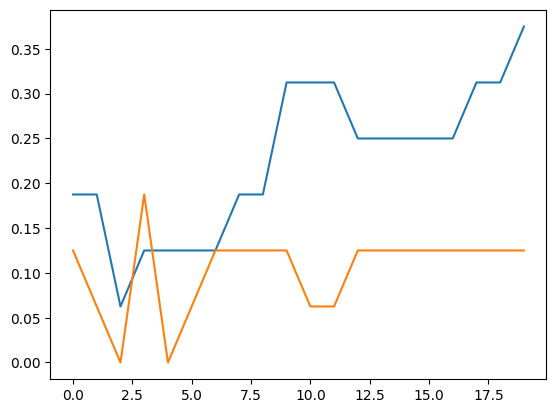

In [22]:
plt.plot(train_history)
plt.plot(val_history)

In [23]:
data_size = 128
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=48, conv2_channels=200)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach 1.0 training accuracy in 50 epochs or less
# Hint: If you have hard time finding the right parameters manually, try grid search or random search!
trainer = Trainer(model, dataset, MomentumSGD(momentum = 0.95), learning_rate=1e-4, num_epochs=100, batch_size=64)

loss_history, train_history, val_history = trainer.fit()

Loss: 12.701880, Train accuracy: 0.132812, val accuracy: 0.148438
Loss: 17.695827, Train accuracy: 0.101562, val accuracy: 0.078125
Loss: 26.530990, Train accuracy: 0.078125, val accuracy: 0.054688
Loss: 32.859659, Train accuracy: 0.101562, val accuracy: 0.171875
Loss: 27.408095, Train accuracy: 0.109375, val accuracy: 0.078125
Loss: 22.895175, Train accuracy: 0.117188, val accuracy: 0.046875
Loss: 17.163912, Train accuracy: 0.132812, val accuracy: 0.109375
Loss: 25.567959, Train accuracy: 0.171875, val accuracy: 0.187500
Loss: 36.156686, Train accuracy: 0.078125, val accuracy: 0.164062
Loss: 25.575003, Train accuracy: 0.234375, val accuracy: 0.195312
Loss: 23.629018, Train accuracy: 0.140625, val accuracy: 0.085938
Loss: 24.742650, Train accuracy: 0.156250, val accuracy: 0.093750
Loss: 31.057430, Train accuracy: 0.140625, val accuracy: 0.148438
Loss: 24.784185, Train accuracy: 0.265625, val accuracy: 0.203125
Loss: 20.293352, Train accuracy: 0.250000, val accuracy: 0.187500
Loss: 15.6

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = StepLR(optimizer, step_size = 1, gamma = 1.0)):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        scheduler.step()
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):

            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            indices = torch.argmax(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))

    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!

    with torch.no_grad():
        correct_samples = 0;
        total_samples = 0;
        for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu);
            indices = torch.argmax(prediction, 1);
            correct_samples += torch.sum(indices == y_gpu);
            total_samples += y.shape[0];

        val_accuracy = float(correct_samples) / total_samples;
    return val_accuracy;